# Modeling Code

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1. 加载数据集
df = pd.read_csv('fps_encoding.csv')

In [ ]:
# 2. 特征定义与选择
# 数值特征：社区人口结构 + 年龄
# numeric_features = [col for col in df.columns if 'share_' in col] + ['age']
numeric_features = ['age']

# 分类特征（需要 One-Hot 编码）：威胁类型、逃跑状态、性别
categorical_features = ['threat_type', 'flee_status', 'gender', 'race']

# 二元特征（已经是 0/1）：武器类型
# binary_features = ['has_gun', 'has_knife', 'has_blunt_object', 'has_vehicle', 'has_replica', 'has_unarmed', 'has_other']

binary_features = ['has_gun', 'has_knife', 'has_blunt_object', 'has_vehicle', 'has_replica', 'has_unarmed', 'has_other']

# 验证变量
validation_features = ['was_mental_illness_related', 'body_camera']

In [ ]:
# 3. 预处理
# 编码与标准化
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(df[categorical_features])
encoded_cat_names = encoder.get_feature_names_out(categorical_features)

scaler = StandardScaler()
scaled_nums = scaler.fit_transform(df[numeric_features])


# 合并建模特征矩阵 (X)
X_modeling = np.hstack((scaled_nums, df[binary_features].values, encoded_cats))

Clusters (K=2): Silhouette Score = 0.1620
Clusters (K=3): Silhouette Score = 0.1381
Clusters (K=4): Silhouette Score = 0.0988
Clusters (K=5): Silhouette Score = 0.1299
Clusters (K=6): Silhouette Score = 0.1136
Clusters (K=7): Silhouette Score = 0.1148
Clusters (K=8): Silhouette Score = 0.1153
Clusters (K=9): Silhouette Score = 0.1123
Clusters (K=10): Silhouette Score = 0.1240


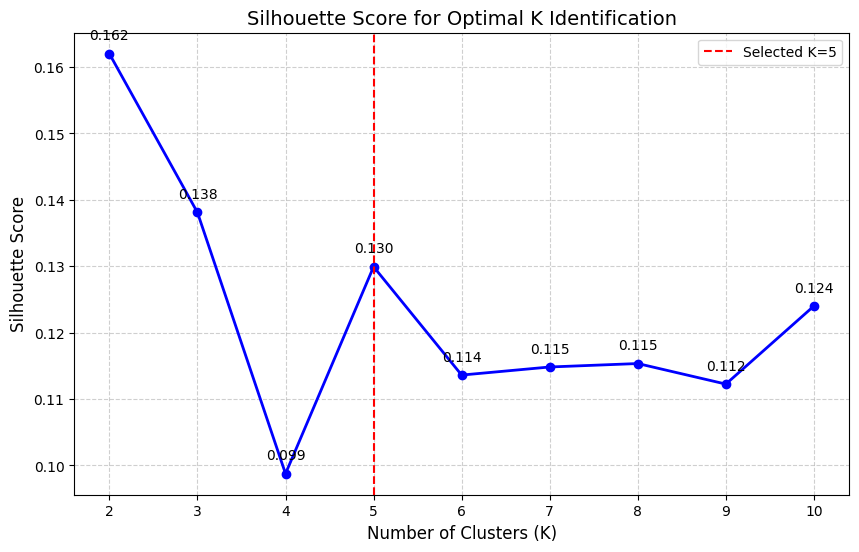

In [ ]:
# 4. 算法对比与 K 值验证

# 4.1 Silhouette Score 计算 (K=2 到 10)

scores = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_modeling)
    score = silhouette_score(X_modeling, labels)
    scores.append(score)
    # 实时打印每个 K 的数值
    print(f"Clusters (K={k}): Silhouette Score = {score:.4f}")

# 可视化输出
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o', linestyle='-', color='b', linewidth=2)

# 添加数值标注，方便直接读图
for i, txt in enumerate(scores):
    plt.annotate(f'{txt:.3f}', (k_range[i], scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Silhouette Score for Optimal K Identification', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.6)
# plt.axvline(x=6, color='r', linestyle='--', label='Optimal K=6')
plt.axvline(x=5, color='r', linestyle='--', label='Selected K=5')

plt.legend()
plt.show()

K=2, Inertia=16391.53
K=3, Inertia=14934.43
K=4, Inertia=14157.61
K=5, Inertia=13499.84
K=6, Inertia=12963.96
K=7, Inertia=12559.66
K=8, Inertia=12197.96
K=9, Inertia=11862.20
K=10, Inertia=11484.32


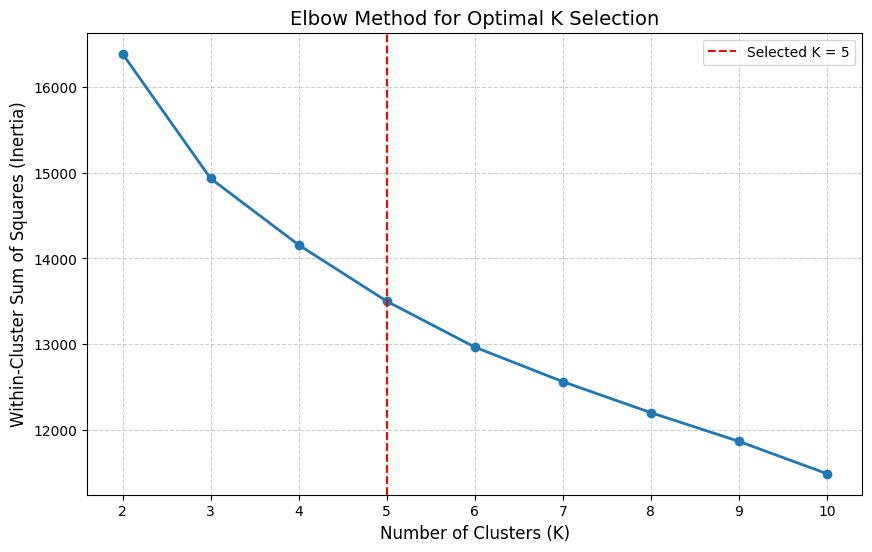

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Range of K to test
k_range = range(2, 11)

inertias = []

for k in k_range:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    km.fit(X_modeling)
    inertias.append(km.inertia_)
    print(f"K={k}, Inertia={km.inertia_:.2f}")

plt.figure(figsize=(10, 6))

plt.plot(
    k_range,
    inertias,
    marker='o',
    linestyle='-',
    linewidth=2
)

plt.axvline(x=5, color='red', linestyle='--', label='Selected K = 5')

plt.title('Elbow Method for Optimal K Selection', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()



In [ ]:
# 4.2 算法比较 (K=5)
k_best = 5
kmeans = KMeans(n_clusters=k_best, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_modeling)

hierarchical = AgglomerativeClustering(n_clusters=k_best)
labels_hier = hierarchical.fit_predict(X_modeling)

# 计算一致性指标 ARI
ari = adjusted_rand_score(labels_km, labels_hier)
print(f"模型验证")
print(f"K=5 时的轮廓系数 (Silhouette Score): {scores[k_best-2]:.4f}")
print(f"K-Means 与 层次聚类的一致性 (ARI): {ari:.4f}")

df['cluster'] = labels_km


=== 模型验证 ===
K=5 时的轮廓系数 (Silhouette Score): 0.1299
K-Means 与 层次聚类的一致性 (ARI): 0.2817


In [ ]:
# 4.3 聚类稳定性验证（不同随机种子）
scores_stability = []
for seed in [0, 21, 42, 100]:
    km = KMeans(n_clusters=k_best, random_state=seed, n_init=10)
    labels = km.fit_predict(X_modeling)
    scores_stability.append(silhouette_score(X_modeling, labels))

print("Stability check (Silhouette Scores across random seeds):", scores_stability)

np.mean(scores_stability), np.std(scores_stability)


Stability check (Silhouette Scores across random seeds): [np.float64(0.11395051608489103), np.float64(0.11363233064262931), np.float64(0.12991996170501546), np.float64(0.1302575312633235)]


(np.float64(0.12194008492396483), np.float64(0.008150311933941697))

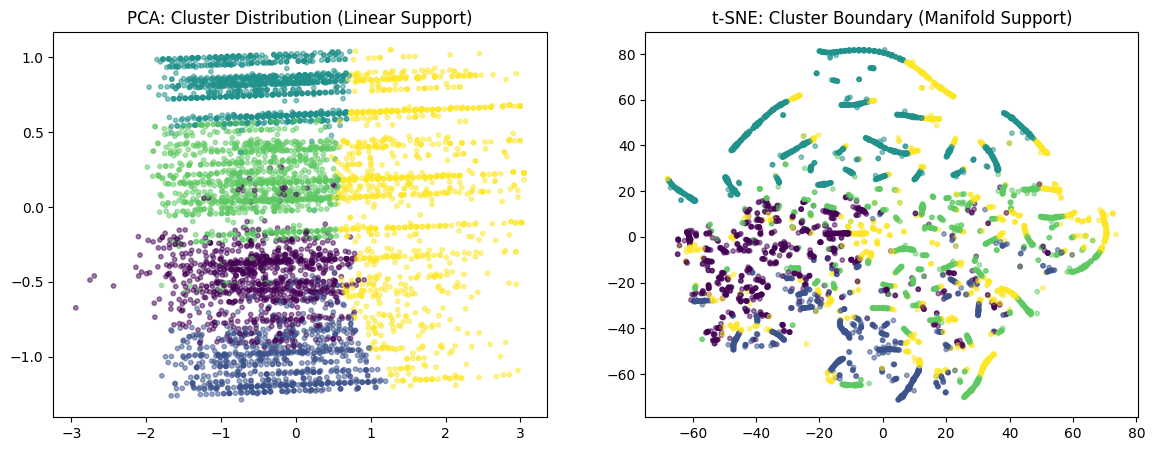

In [ ]:
# 5. 可视化辅助检查 (回应组长：辅助工具定位)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_modeling)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_modeling)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', s=10, alpha=0.5)
plt.title('PCA: Cluster Distribution (Linear Support)')

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['cluster'], cmap='viridis', s=10, alpha=0.5)
plt.title('t-SNE: Cluster Boundary (Manifold Support)')
plt.show()

In [ ]:
# 6. 聚类特征解读 (回应组长：二元变量百分比化)

# 准备画像数据
# 数值变量用均值
res_numeric = df.groupby('cluster')[numeric_features].mean()

# 二元变量和编码变量转化为百分比 (%)
# 首先把编码后的分类变量放回 dataframe
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_cat_names)
df_for_analysis = pd.concat([df[['cluster'] + binary_features + validation_features], encoded_df], axis=1)

# 将 bool 或 0/1 转化为 100% 格式
res_percent = df_for_analysis.groupby('cluster').mean() * 100

# 最终汇总表
cluster_profile = pd.concat([res_numeric, res_percent], axis=1)

<Figure size 1200x600 with 0 Axes>

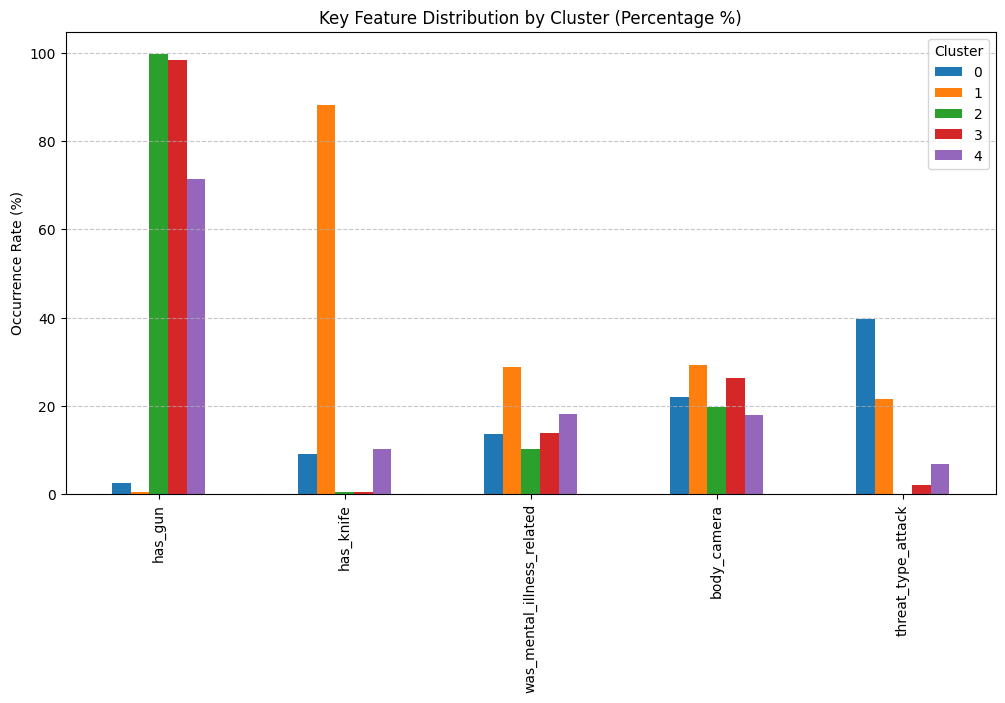


聚类特征汇总表（部分）：


,age,has_gun,has_knife,has_blunt_object,has_vehicle,has_replica,has_unarmed,has_other,was_mental_illness_related,body_camera,...,race_H,race_N,race_N;H,race_O,race_W,race_W;A,race_W;B,race_W;B;N,race_W;H,race_unknown
cluster,,,,,,,,,,,,,,,,,,,,,
0,32.769314,2.502720,9.140370,6.528836,22.198041,5.331882,20.130577,3.482046,13.601741,22.089227,...,16.974973,2.176279,0.108814,0.108814,40.587595,0.000000,0.000000,0.000000,0.000000,13.819369
1,34.673367,0.376884,88.190955,4.020101,0.502513,4.522613,0.879397,1.507538,28.768844,29.145729,...,25.000000,1.381910,0.000000,0.753769,38.944724,0.125628,0.125628,0.125628,0.125628,14.321608
2,32.463394,99.833611,0.499168,0.000000,0.665557,0.000000,0.000000,0.249584,10.232945,19.717138,...,15.058236,0.831947,0.000000,0.332779,36.772047,0.000000,0.083195,0.000000,0.083195,11.647255
3,31.297064,98.445596,0.518135,0.086356,0.777202,1.468048,0.000000,0.172712,13.730570,26.252159,...,17.789292,1.036269,0.000000,0.431779,35.924007,0.000000,0.172712,0.000000,0.086356,12.089810
4,56.108541,71.530249,10.142349,1.957295,3.647687,3.113879,2.135231,0.800712,18.060498,17.971530,...,6.583630,0.889680,0.000000,0.266904,63.256228,0.000000,0.000000,0.000000,0.000000,16.370107


In [ ]:
# 可视化核心特征模式 (选取组长关心的几个变量)
target_cols = ['has_gun', 'has_knife', 'was_mental_illness_related', 'body_camera', 'threat_type_attack']
plt.figure(figsize=(12, 6))
res_percent[target_cols].T.plot(kind='bar', figsize=(12, 6))
plt.title('Key Feature Distribution by Cluster (Percentage %)')
plt.ylabel('Occurrence Rate (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Cluster')
plt.show()

# 导出结果供报告使用
cluster_profile.to_csv('cluster_interpretation_results.csv')
print("\n聚类特征汇总表（部分）：")
cluster_profile.head()

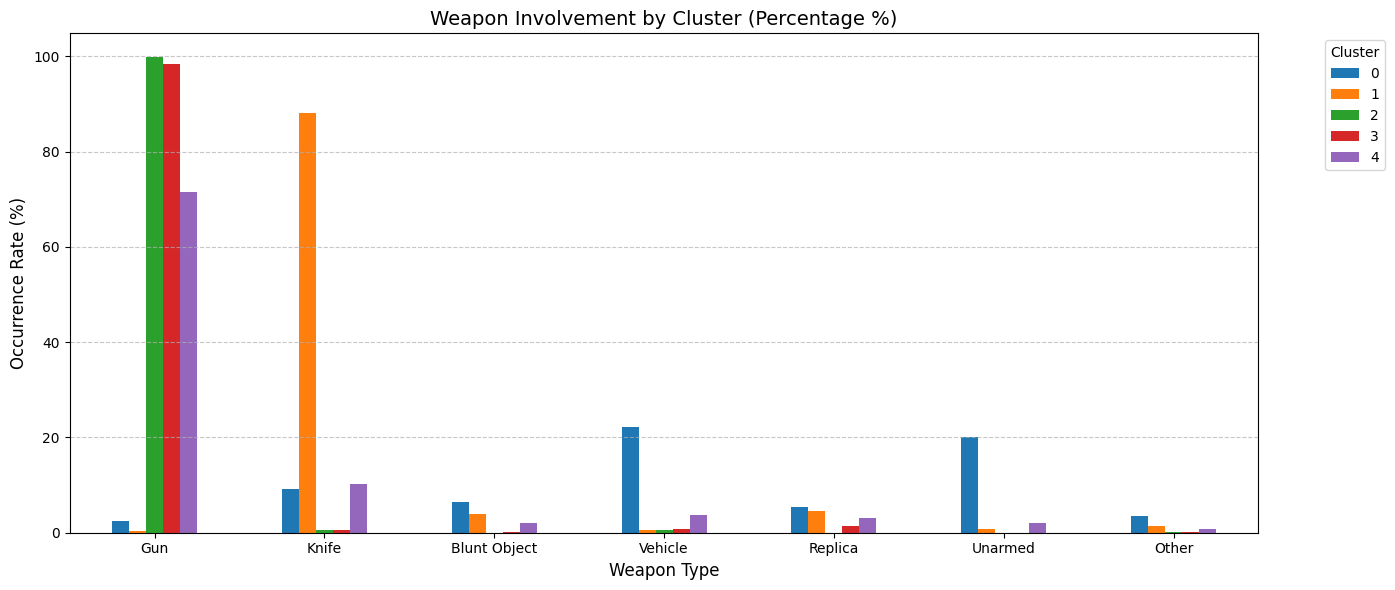

In [ ]:
# Automatically select all weapon-related variables
weapon_cols = [c for c in res_percent.columns if c.startswith('has_')]

# Create plot
ax = res_percent[weapon_cols].T.plot(
    kind='bar',
    figsize=(14, 6)
)

# Clean x-axis labels
ax.set_xticklabels(
    [c.replace('has_', '').replace('_', ' ').title() for c in weapon_cols],
    rotation=0
)

# Formatting
ax.set_title('Weapon Involvement by Cluster (Percentage %)', fontsize=14)
ax.set_ylabel('Occurrence Rate (%)', fontsize=12)
ax.set_xlabel('Weapon Type', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Legend
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


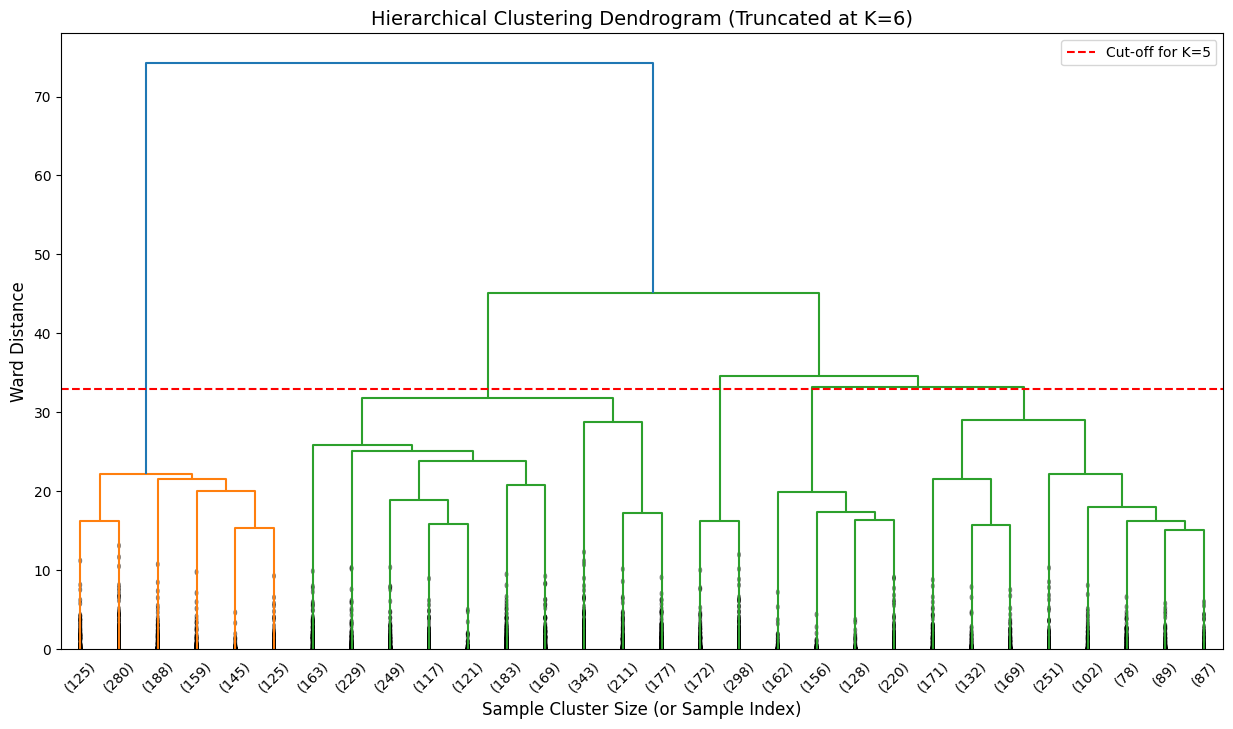

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from scipy.cluster.hierarchy import fcluster

# 1. 层次聚类谱系图 (Dendrogram)
# 使用 Ward 方法，它能最小化簇内方差，与 K-Means 的逻辑最匹配
Z = linkage(X_modeling, method='ward')

plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram (Truncated at K=6)', fontsize=14)
plt.xlabel('Sample Cluster Size (or Sample Index)', fontsize=12)
plt.ylabel('Ward Distance', fontsize=12)

# truncate_mode='lastp' 只显示最后合并的 p 个节点
# p=30 能让你清晰地看到顶层的合并结构
dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=45.,
    leaf_font_size=10.,
    show_contracted=True
)

# 添加一条红线，代表截断出 6 个簇的位置
# y 的值可以根据你运行出的图表高度微调，通常在最后几个大合并的间隙
plt.axhline(y=33, color='r', linestyle='--', label='Cut-off for K=5')
plt.legend()
plt.show()



In [ ]:
from scipy.cluster.hierarchy import fcluster

labels = fcluster(Z, t=33, criterion='distance')
len(set(labels))

5

In [ ]:
# Compare result with kmeans

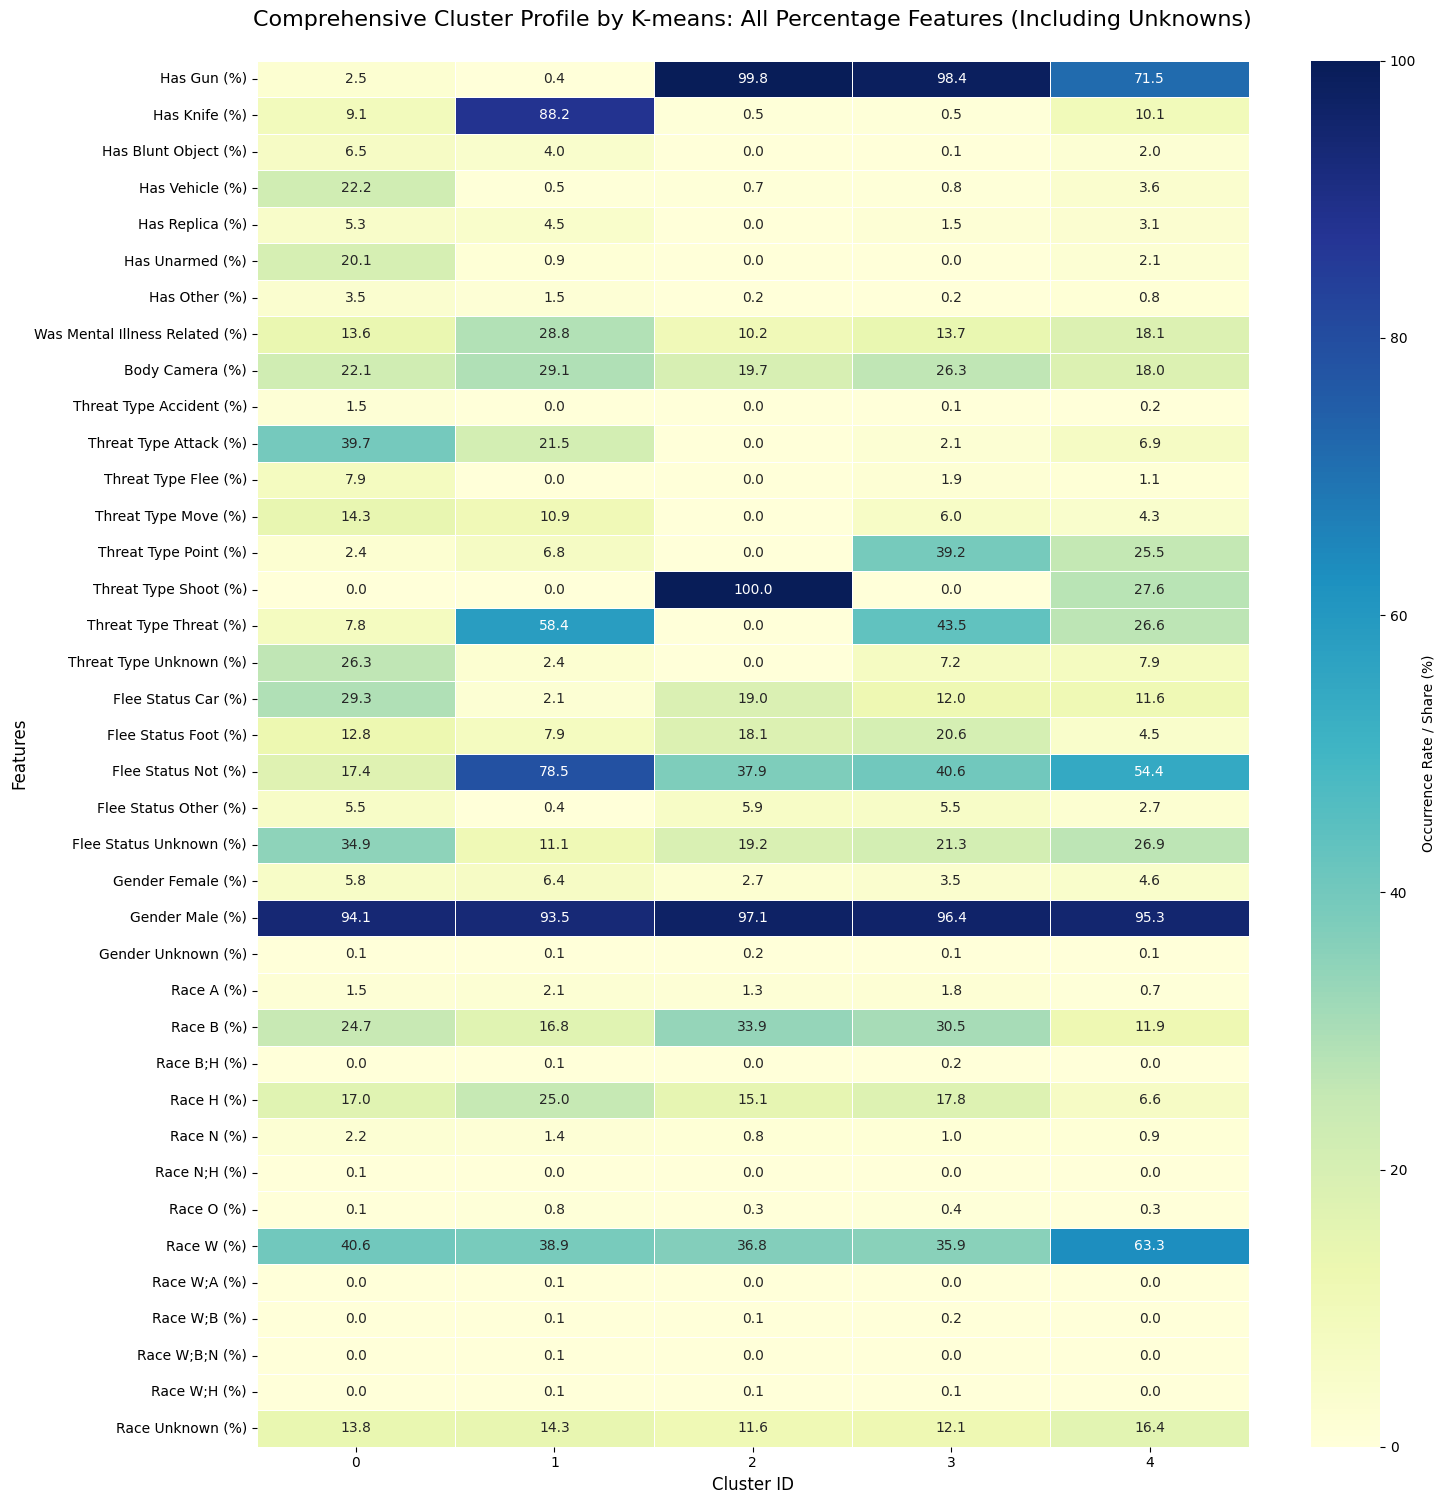

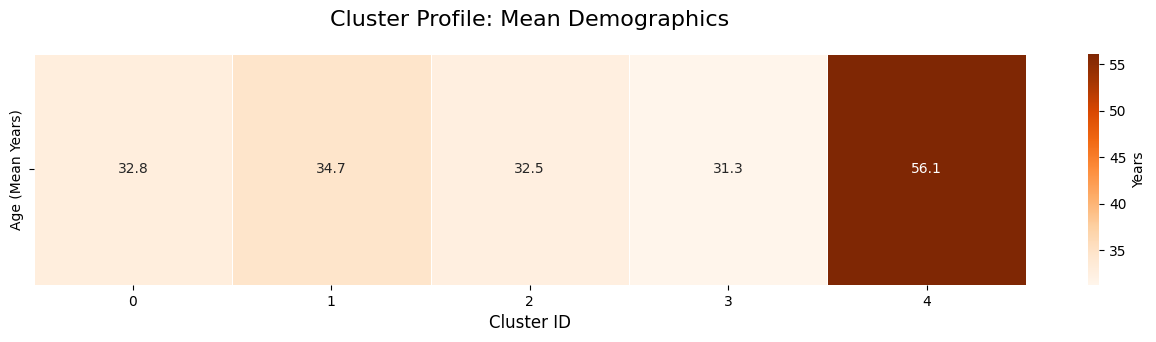

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 8. 全特征热力图 (自动提取所有维度)
# 8.1 数据清洗与比例对齐
df_plot = cluster_profile.copy()

# 1. 将所有比例变量 (share_*) 统一为 0-100 格式
share_cols = [c for c in df_plot.columns if 'share_' in c]
for col in share_cols:
    if df_plot[col].max() <= 1.1: # 容错处理
        df_plot[col] = df_plot[col] * 100

# 2. 自动对列进行逻辑分组并排序，确保图表整齐
# 分为：种族比例、武器类型、验证变量、威胁类型、逃跑状态、性别
cols_demographic = [c for c in df_plot.columns if 'share_' in c]
cols_weapon = [c for c in df_plot.columns if 'has_' in c]
cols_validation = ['was_mental_illness_related', 'body_camera']
cols_threat = [c for c in df_plot.columns if 'threat_type_' in c]
cols_flee = [c for c in df_plot.columns if 'flee_status_' in c]
cols_gender = [c for c in df_plot.columns if 'gender_' in c]
# hongxuan
cols_race = [c for c in df_plot.columns if 'race_' in c]

# 合并所有百分比类特征（不含 age）
all_pct_features = cols_demographic + cols_weapon + cols_validation + cols_threat + cols_flee + cols_gender + cols_race

# 8.2 绘制图表 1：全百分比特征图 (0-100%)
plt.figure(figsize=(16, 18)) # 增加高度以容纳所有特征

pct_data = df_plot[all_pct_features].T

# 优化标签名称：去除下划线并首字母大写
pct_data.index = [i.replace('_', ' ').title() + ' (%)' for i in pct_data.index]

sns.heatmap(
    pct_data,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=.5,
    vmin=0, vmax=100,
    cbar_kws={'label': 'Occurrence Rate / Share (%)'}
)

plt.title('Comprehensive Cluster Profile by K-means: All Percentage Features (Including Unknowns)', fontsize=16, pad=25)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

# 8.3 绘制图表 2：均值特征图 (Age)
plt.figure(figsize=(16, 3))
mean_data = df_plot[['age']].T
mean_data.index = ['Age (Mean Years)']

sns.heatmap(
    mean_data,
    annot=True,
    fmt=".1f",
    cmap="Oranges",
    linewidths=.5,
    cbar_kws={'label': 'Years'}
)

plt.title('Cluster Profile: Mean Demographics', fontsize=16, pad=20)
plt.xlabel('Cluster ID', fontsize=12)
plt.show()

In [ ]:
df_plot.head()

,age,has_gun,has_knife,has_blunt_object,has_vehicle,has_replica,has_unarmed,has_other,was_mental_illness_related,body_camera,...,race_H,race_N,race_N;H,race_O,race_W,race_W;A,race_W;B,race_W;B;N,race_W;H,race_unknown
cluster,,,,,,,,,,,,,,,,,,,,,
0,32.769314,2.502720,9.140370,6.528836,22.198041,5.331882,20.130577,3.482046,13.601741,22.089227,...,16.974973,2.176279,0.108814,0.108814,40.587595,0.000000,0.000000,0.000000,0.000000,13.819369
1,34.673367,0.376884,88.190955,4.020101,0.502513,4.522613,0.879397,1.507538,28.768844,29.145729,...,25.000000,1.381910,0.000000,0.753769,38.944724,0.125628,0.125628,0.125628,0.125628,14.321608
2,32.463394,99.833611,0.499168,0.000000,0.665557,0.000000,0.000000,0.249584,10.232945,19.717138,...,15.058236,0.831947,0.000000,0.332779,36.772047,0.000000,0.083195,0.000000,0.083195,11.647255
3,31.297064,98.445596,0.518135,0.086356,0.777202,1.468048,0.000000,0.172712,13.730570,26.252159,...,17.789292,1.036269,0.000000,0.431779,35.924007,0.000000,0.172712,0.000000,0.086356,12.089810
4,56.108541,71.530249,10.142349,1.957295,3.647687,3.113879,2.135231,0.800712,18.060498,17.971530,...,6.583630,0.889680,0.000000,0.266904,63.256228,0.000000,0.000000,0.000000,0.000000,16.370107


In [ ]:
from scipy.cluster.hierarchy import fcluster

# Cut dendrogram to get 5 clusters
hclust_labels_k5 = fcluster(Z, t=5, criterion='maxclust')

df['hclust_k5'] = hclust_labels_k5

In [ ]:
print("K-means cluster sizes:")
print(df['cluster'].value_counts().sort_index())

print("\nHierarchical cluster sizes:")
print(df['hclust_k5'].value_counts().sort_index())


K-means cluster sizes:
cluster
0     919
1     796
2    1202
3    1158
4    1124
Name: count, dtype: int64

Hierarchical cluster sizes:
hclust_k5
1    1022
2    1962
3     470
4     666
5    1079
Name: count, dtype: int64


In [ ]:
res_numeric = df.groupby('hclust_k5')[numeric_features].mean()

# 二元变量和编码变量转化为百分比 (%)
# 首先把编码后的分类变量放回 dataframe
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_cat_names)
df_for_analysis = pd.concat([df[['hclust_k5'] + binary_features + validation_features], encoded_df], axis=1)

# 将 bool 或 0/1 转化为 100% 格式
res_percent = df_for_analysis.groupby('hclust_k5').mean() * 100

# 最终汇总表
cluster_profile_hc = pd.concat([res_numeric, res_percent], axis=1)

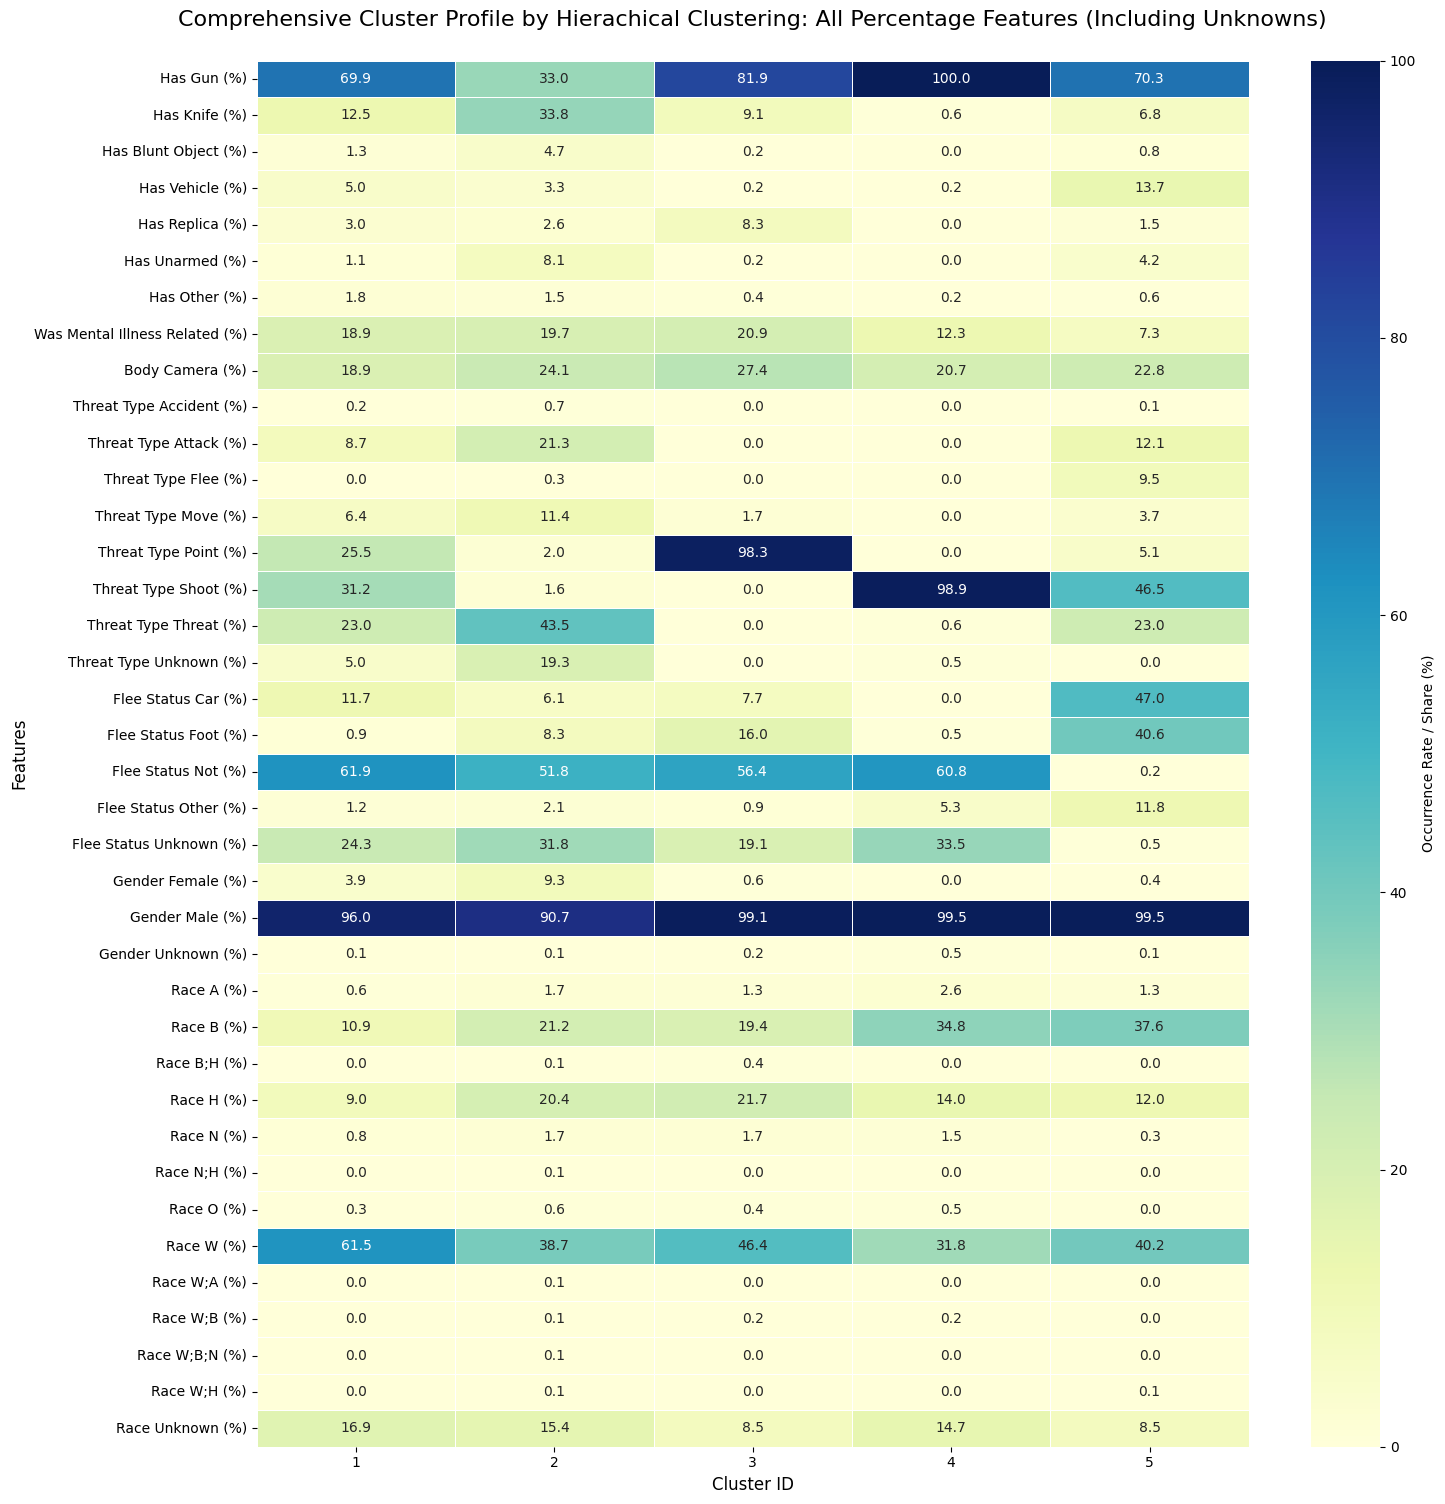

In [ ]:
df_plot_hc = cluster_profile_hc.copy()
# 1. 将所有比例变量 (share_*) 统一为 0-100 格式
share_cols = [c for c in df_plot_hc.columns if 'share_' in c]
for col in share_cols:
    if df_plot_hc[col].max() <= 1.1: # 容错处理
        df_plot_hc[col] = df_plot_hc[col] * 100

# 2. 自动对列进行逻辑分组并排序，确保图表整齐
# 分为：种族比例、武器类型、验证变量、威胁类型、逃跑状态、性别
cols_demographic = [c for c in df_plot_hc.columns if 'share_' in c]
cols_weapon = [c for c in df_plot_hc.columns if 'has_' in c]
cols_validation = ['was_mental_illness_related', 'body_camera']
cols_threat = [c for c in df_plot_hc.columns if 'threat_type_' in c]
cols_flee = [c for c in df_plot_hc.columns if 'flee_status_' in c]
cols_gender = [c for c in df_plot_hc.columns if 'gender_' in c]
# hongxuan
cols_race = [c for c in df_plot_hc.columns if 'race_' in c]

# 合并所有百分比类特征（不含 age）
all_pct_features = cols_demographic + cols_weapon + cols_validation + cols_threat + cols_flee + cols_gender + cols_race

# 8.2 绘制图表 1：全百分比特征图 (0-100%)
plt.figure(figsize=(16, 18)) # 增加高度以容纳所有特征

pct_data = df_plot_hc[all_pct_features].T

# 优化标签名称：去除下划线并首字母大写
pct_data.index = [i.replace('_', ' ').title() + ' (%)' for i in pct_data.index]

sns.heatmap(
    pct_data,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=.5,
    vmin=0, vmax=100,
    cbar_kws={'label': 'Occurrence Rate / Share (%)'}
)

plt.title('Comprehensive Cluster Profile by Hierachical Clustering: All Percentage Features (Including Unknowns)', fontsize=16, pad=25)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()


In [ ]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(
    df['cluster'],
    df['hclust_k5']
)
print(f"Adjusted Rand Index: {ari:.3f}")


Adjusted Rand Index: 0.282


In [ ]:
# 1. 根据图片中的列名定义列表
race_cols = ['share_white', 'share_black', 'share_unknowntive_american', 'share_asian', 'share_hispanic', 'share_two_or_more']

# 2. 方法一：使用 .all(axis=1) 检查是否每一列都等于 0
# 这种方法最严谨，专门针对“全为0”的逻辑
zero_race_mask = (df[race_cols] == 0).all(axis=1)

# 3. 统计结果
zero_race_samples = df[zero_race_mask]
num_zero = len(zero_race_samples)

print(f" 检查报告 ")
print(f"检测到的种族列: {race_cols}")
print(f"种族特征全部为 0 的样本数量: {num_zero}")
print(f"占总样本比例: {(num_zero / len(df)) * 100:.2f}%")

# 4. 如果存在这类样本，查看前几行以排查原因
if num_zero > 0:
    print("\n[全0样本示例]:")
    print(zero_race_samples.head())
else:
    print("\n[结果]: 没有发现种族特征全为 0 的样本。")

================ 检查报告 ================
检测到的种族列: ['share_white', 'share_black', 'share_unknowntive_american', 'share_asian', 'share_hispanic', 'share_two_or_more']
种族特征全部为 0 的样本数量: 724
占总样本比例: 13.93%

[全0样本示例]:
     row_id threat_type flee_status                 armed_with  \
24       25       shoot         car                        gun   
91     3966      attack         not  blunt_object;blunt_object   
92       93      threat         not                      knife   
103     104       point         not                        gun   
136     137       shoot         car                        gun   

               city state         latitude        longitude  age     race  \
24           nipton    CA  Unknown/Missing  Unknown/Missing   27  unknown   
91   rockaway beach    OR       45.6147248       -123.93724   42  unknown   
92             yuma    AZ        32.743007       -114.48748   63  unknown   
103     kansas city    MO        39.103318       -94.546044   32  unknown   
136     

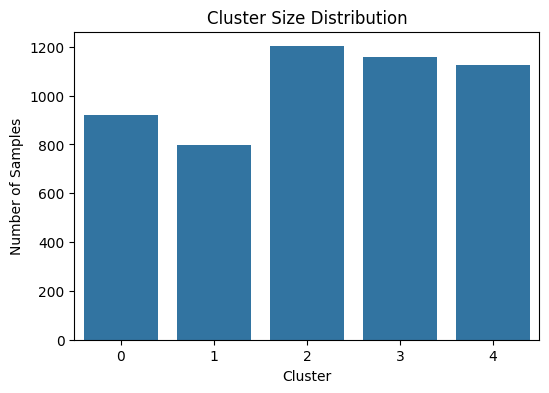

In [ ]:
#每个聚类的占比大小
plt.figure(figsize=(6, 4))
sns.countplot(x=df['cluster'])
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Samples")
plt.show()


In [ ]:
df.to_csv("df_main_clusterv2.csv")